In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

## Load the data 
40 subjects, each with 10 pictures

In [2]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content')

In [3]:
# Set directory to access pictures
face_data = '/content/Faces' 

In [4]:
# Initialize lists to hold image data (flattened for Random Forest and Logistic Regression and original 2D for CNN) and its label
X_data = []
y_data = []
X_data_original = []

In [5]:
# Iterate through dataset directory
for dir_name in os.listdir(face_data):
    if os.path.isdir(os.path.join(face_data, dir_name)):
        label = dir_name
        for img_name in os.listdir(os.path.join(face_data, dir_name)):
            img_path = os.path.join(face_data, dir_name, img_name)
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            img_flattened = img_array.flatten() # flatten from 2D array to 1D array
            X_data.append(img_flattened)
            y_data.append(label)
            X_data_original.append(img_array) # keep original 2D array

## Exploratory Data Analysis

### Check a specific subject's image set

In [6]:
# Accessing the data for a specific set of images
set_number = 's14' 
set_images = [img for img, label in zip(X_data, y_data) if label == set_number]

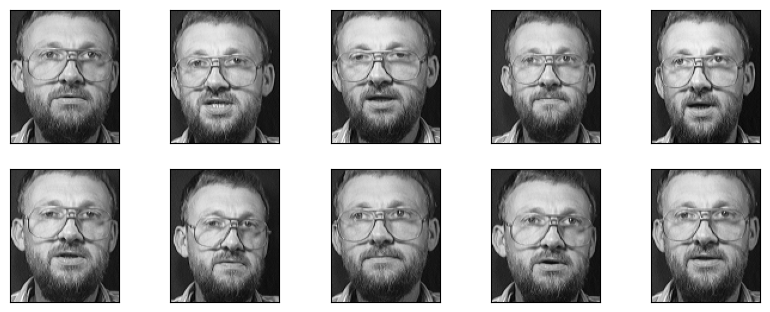

In [7]:
# Print the images from the specified set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
plt.show()

### Image Stats

In [8]:
# Initialize a dictionary to hold average pixel intensities for each class
average_pixel_intensities = {}

# Iterate over each class
for class_name in set(y_data):
    # Find all images belonging to this class
    class_images = [image for image, label in zip(X_data, y_data) if label == class_name]
    
    # Calculate average pixel intensity for this class
    average_pixel_intensity = np.mean([np.mean(image) for image in class_images])
    
    # Store the result in our dictionary
    average_pixel_intensities[class_name] = average_pixel_intensity

# Print the results
for class_name, avg_intensity in average_pixel_intensities.items():
    print(f"Average pixel intensity for {class_name}: {avg_intensity}")

Average pixel intensity for s1: 136.7014072204969
Average pixel intensity for s26: 121.01328610248447
Average pixel intensity for s24: 103.14790372670807
Average pixel intensity for s40: 123.42201086956523
Average pixel intensity for s15: 112.20925854037266
Average pixel intensity for s6: 138.23907220496895
Average pixel intensity for s39: 83.92661102484472
Average pixel intensity for s22: 85.1676921583851
Average pixel intensity for s28: 111.90132958074534
Average pixel intensity for s19: 120.02870729813665
Average pixel intensity for s31: 106.60304736024845
Average pixel intensity for s36: 111.48193905279501
Average pixel intensity for s10: 104.09259510869565
Average pixel intensity for s27: 113.87108889751553
Average pixel intensity for s14: 102.43626746894411
Average pixel intensity for s23: 111.16773097826088
Average pixel intensity for s37: 109.10439635093167
Average pixel intensity for s29: 91.63590838509317
Average pixel intensity for s13: 129.1649844720497
Average pixel intens

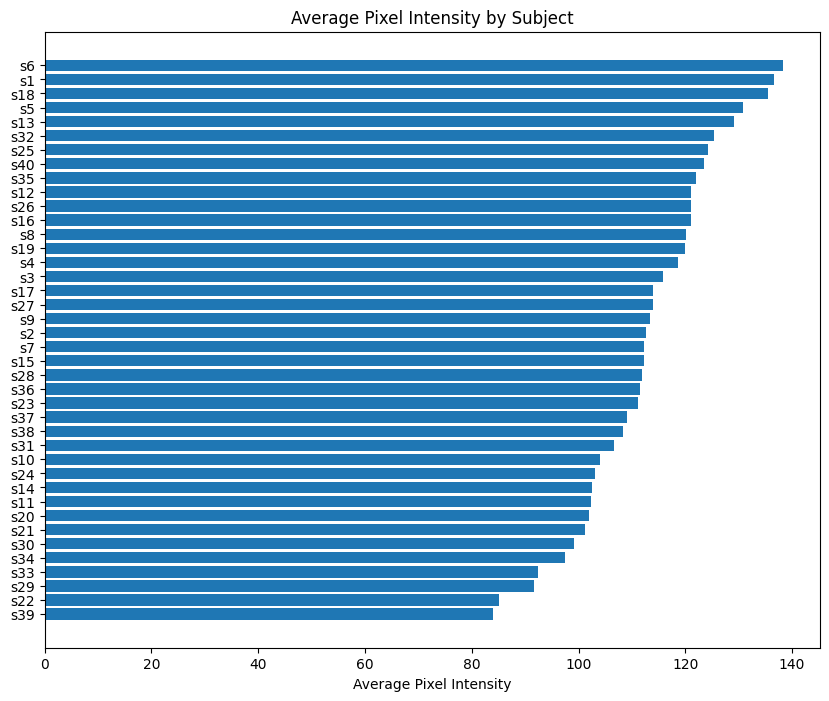

In [9]:
# Create DataFrame from dictionary
average_pixel_intensities_df = pd.DataFrame(list(average_pixel_intensities.items()), columns=['Subject', 'Average Pixel Intensity'])

# Sort DataFrame by 'Average Pixel Intensity'
average_pixel_intensities_df = average_pixel_intensities_df.sort_values('Average Pixel Intensity')

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(average_pixel_intensities_df['Subject'], average_pixel_intensities_df['Average Pixel Intensity'])
plt.xlabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Subject')
plt.show()

# Machine Learning Models

In [10]:
# Training and Testing Split (used for both Random Forest and Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1, stratify=y_data)

## Random Forest Classifier

Reference: https://notebook.community/mbeyeler/opencv-machine-learning/notebooks/10.03-Using-Random-Forests-for-Face-Recognition

In [11]:
# Assign Random Forest model 
RFmodel = RandomForestClassifier()

# Fit the Random Forest Classifier on the training data
RFmodel.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
# Make predictions on the test set
RF_y_pred = RFmodel.predict(X_test)

In [13]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 95.00%


In [68]:
# Generate a confusion matrix for Random Forest model
RFconfusion_matrix = confusion_matrix(y_test, RF_y_pred)
print(f"Random Forest Confusion Matrix:") 
print(RFconfusion_matrix)

Random Forest Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [15]:
# Print the classification report for Random Forest model
RFclassification_report = classification_report(y_test, RF_y_pred)
print(f"Random Forest Classification Report:")
print(RFclassification_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      1.00      1.00         2
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       0.67      1.00      0.80         2
         s15       1.00      1.00      1.00         2
         s16       1.00      1.00      1.00         2
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         2
         s20       1.00      0.50      0.67         2
         s21       1.00      1.00      1.00         2
         s22       1.00      0.50      0.67         2
         s23       1.00      1.00      1.00         2
         s24       1.00      1.00      1.00 

In [16]:
# Finding Misclassified images in Random Forest

# Convert y_test and RF_y_pred to numpy arrays
y_test_array = np.array(y_test)
RF_y_pred_array = np.array(RF_y_pred)

# Find indices of misclassified examples
RFmisclassified = np.where(y_test_array != RF_y_pred_array)[0]

# Create dataframe of misclassified examples
RFmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[RFmisclassified],
    'Predicted Label': RF_y_pred_array[RFmisclassified]
})

RFmisclassified_df

,True Label,Predicted Label
0,s40,s5
1,s36,s7
2,s22,s14
3,s20,s33


##Logistic Regression

In [17]:
# Scale the data for Logistic Regression
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Assign Logistic Regression model
LRmodel = LogisticRegression(max_iter=2000)

# Fit Logistic Regression model using training data
LRmodel.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [19]:
# Make a prediction using the testing data
LR_y_pred = LRmodel.predict(X_test_scaled)

In [20]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 98.75%


In [21]:
# Generate a confusion matrix for Logistic Regression model
LRconfusion_matrix = confusion_matrix(y_test, LR_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(LRconfusion_matrix)

Logistic Regression Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [22]:
# Print the classification report for Logistic Regression model
LRclassification_report = classification_report(y_test, LR_y_pred)
print(f"Logistic Regression Classification Report:")
print(LRclassification_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      1.00      1.00         2
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         2
         s15       1.00      1.00      1.00         2
         s16       1.00      1.00      1.00         2
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         2
         s20       1.00      1.00      1.00         2
         s21       1.00      1.00      1.00         2
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         2
         s24       1.00      1.00     

In [23]:
# Finding Misclassified images in Logistic Regression

# Convert y_test and LR_y_pred to numpy arrays
y_test_array = np.array(y_test)
LR_y_pred_array = np.array(LR_y_pred)

# Find indices of misclassified examples
LRmisclassified = np.where(y_test_array != LR_y_pred_array)[0]

# Create dataframe of misclassified examples
LRmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[LRmisclassified],
    'Predicted Label': LR_y_pred_array[LRmisclassified]
})

LRmisclassified_df


,True Label,Predicted Label
0,s40,s5


# Convolutional Neural Network (CNN) 
Reference: https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5

In [24]:
# Create numpy array
X_data_original = np.array(X_data_original)
y_data = np.array(y_data)

# Split the original image data into training and testing sets, use random_state 1
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_data_original, y_data, test_size=0.2, random_state=1, stratify=y_data)

print('Original Images:')
print('X_train_original = %s, y_train_original = %s' % (X_train_original.shape, y_train_original.shape))
print('X_test_original = %s, y_test_original = %s' % (X_test_original.shape, y_test_original.shape))

Original Images:
X_train_original = (320, 112, 92), y_train_original = (320,)
X_test_original = (80, 112, 92), y_test_original = (80,)


In [25]:
# Reshaping the array to become 4-dimensional
X_train_original  = X_train_original.reshape(X_train_original.shape[0], 112, 92, 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], 112, 92, 1)

print('After reshaping, X_train_original is :', X_train_original.shape)
print('X_train_original contains', X_train_original.shape[0], "images")
print('X_test_original contains', X_test_original.shape[0], "images")

After reshaping, X_train_original is : (320, 112, 92, 1)
X_train_original contains 320 images
X_test_original contains 80 images


In [26]:
# To ensure decimal points after division
X_train_original = X_train_original.astype('float32')
X_test_original = X_test_original.astype('float32')

# Normalizing the RGB codes by dividing it by the max RGB value
X_train_original /= 255
X_test_original /= 255

In [27]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

In [28]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

In [29]:
# Create a dataframe to store the results for model optimization
results = pd.DataFrame(columns=["Model_Version", "Test_Loss", "Test_Accuracy"])

### CNN Model Version 1 - original codeblock from referenced link

In [30]:
# Creating a sequential model named and adding layers to it
CNN_v1 = models.Sequential()
CNN_v1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v1.add(layers.MaxPooling2D((2, 2)))
CNN_v1.add(layers.Flatten())
CNN_v1.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v1.add(layers.Dense(40, activation='softmax'))

In [31]:
# Compile the model
CNN_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Fit the model
history = CNN_v1.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
y_pred_v1 = CNN_v1.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v1
classification_report_v1 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v1, axis=1), zero_division=0)
print("CNN_v1 Classification Report:")
print(classification_report_v1)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v1
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v1 model
CNN_v1.save("CNN_v1.h5")

Epoch 1/10
8/8 [==============================] - 2s 207ms/step - loss: 12.5754 - accuracy: 0.0234 - val_loss: 6.8100 - val_accuracy: 0.0156
Epoch 2/10
8/8 [==============================] - 1s 183ms/step - loss: 4.8241 - accuracy: 0.0273 - val_loss: 3.6858 - val_accuracy: 0.0312
Epoch 3/10
8/8 [==============================] - 2s 192ms/step - loss: 3.6882 - accuracy: 0.0234 - val_loss: 3.6890 - val_accuracy: 0.0156
Epoch 4/10
8/8 [==============================] - 2s 294ms/step - loss: 3.6889 - accuracy: 0.0273 - val_loss: 3.6895 - val_accuracy: 0.0156
Epoch 5/10
8/8 [==============================] - 1s 188ms/step - loss: 3.6888 - accuracy: 0.0234 - val_loss: 3.6902 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 1s 183ms/step - loss: 3.6886 - accuracy: 0.0312 - val_loss: 3.6908 - val_accuracy: 0.0000e+00
Epoch 7/10
8/8 [==============================] - 1s 186ms/step - loss: 3.6885 - accuracy: 0.0312 - val_loss: 3.6916 - val_accuracy: 0.0000e+00
Epoch 8

<ipython-input-32-5e4559fa928d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 2 - added a convolutional layer

In [33]:
# Creating a sequential model named and adding layers to it
CNN_v2 = models.Sequential()
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))
CNN_v2.add(layers.Flatten())
CNN_v2.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v2.add(layers.Dense(40, activation='softmax'))

In [34]:
# Compile the model
CNN_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Fit the model
history = CNN_v2.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
y_pred_v2 = CNN_v2.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v2
classification_report_v2 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v2, axis=1))
print("CNN_v2 Classification Report:")
print(classification_report_v2)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v2
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v2 model
CNN_v2.save("CNN_v2.h5")

Epoch 1/10
8/8 [==============================] - 3s 254ms/step - loss: 4.5183 - accuracy: 0.0430 - val_loss: 3.7904 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 2s 244ms/step - loss: 3.6399 - accuracy: 0.0508 - val_loss: 3.6727 - val_accuracy: 0.0312
Epoch 3/10
8/8 [==============================] - 2s 237ms/step - loss: 3.5429 - accuracy: 0.0977 - val_loss: 3.5822 - val_accuracy: 0.0312
Epoch 4/10
8/8 [==============================] - 3s 461ms/step - loss: 3.4013 - accuracy: 0.1289 - val_loss: 3.4749 - val_accuracy: 0.0938
Epoch 5/10
8/8 [==============================] - 4s 455ms/step - loss: 3.1151 - accuracy: 0.2773 - val_loss: 3.3086 - val_accuracy: 0.0781
Epoch 6/10
8/8 [==============================] - 4s 452ms/step - loss: 2.7379 - accuracy: 0.3242 - val_loss: 3.0862 - val_accuracy: 0.1875
Epoch 7/10
8/8 [==============================] - 4s 565ms/step - loss: 2.2873 - accuracy: 0.4648 - val_loss: 2.6770 - val_accuracy: 0.2656
Epoch 8/10
8/8 [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 45ms/step - loss: 1.4209 - accuracy: 0.6000


<ipython-input-35-ace8be32a4ee>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 3 - doubled epochs from 10 to 20

In [36]:
# Creating a sequential model named and adding layers to it
CNN_v3 = models.Sequential()
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v3.add(layers.MaxPooling2D((2, 2)))
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v3.add(layers.MaxPooling2D((2, 2)))
CNN_v3.add(layers.Flatten())
CNN_v3.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v3.add(layers.Dense(40, activation='softmax'))

In [37]:
# Compile the model
CNN_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Fit the model
history = CNN_v3.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
y_pred_v3 = CNN_v3.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v3
classification_report_v3 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v3, axis=1))
print("CNN_v3 Classification Report:")
print(classification_report_v3)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v3
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v3 model
CNN_v3.save("CNN_v3.h5")

Epoch 1/20
8/8 [==============================] - 3s 312ms/step - loss: 4.7893 - accuracy: 0.0391 - val_loss: 3.7458 - val_accuracy: 0.0312
Epoch 2/20
8/8 [==============================] - 2s 241ms/step - loss: 3.6744 - accuracy: 0.0156 - val_loss: 3.6811 - val_accuracy: 0.0469
Epoch 3/20
8/8 [==============================] - 2s 238ms/step - loss: 3.5565 - accuracy: 0.0938 - val_loss: 3.5562 - val_accuracy: 0.0625
Epoch 4/20
8/8 [==============================] - 2s 231ms/step - loss: 3.3017 - accuracy: 0.2070 - val_loss: 3.2846 - val_accuracy: 0.1719
Epoch 5/20
8/8 [==============================] - 2s 237ms/step - loss: 2.8279 - accuracy: 0.3750 - val_loss: 2.9302 - val_accuracy: 0.2969
Epoch 6/20
8/8 [==============================] - 2s 299ms/step - loss: 2.2095 - accuracy: 0.4766 - val_loss: 2.4336 - val_accuracy: 0.3438
Epoch 7/20
8/8 [==============================] - 2s 285ms/step - loss: 1.5600 - accuracy: 0.6484 - val_loss: 1.9773 - val_accuracy: 0.4844
Epoch 8/20
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-38-8e8af20091f0>:19: FutureWarning: The frame.app

### CNN Model Version 4 - added a third convolutional layer

In [39]:
# Creating a sequential model named and adding layers to it
CNN_v4 = models.Sequential()
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))
CNN_v4.add(layers.Flatten())
CNN_v4.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.Dense(40, activation='softmax'))

In [40]:
# Compile the model
CNN_v4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Fit the model
history = CNN_v4.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
y_pred_v4 = CNN_v4.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v4
classification_report_v4 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v4, axis=1))
print("CNN_v4 Classification Report:")
print(classification_report_v4)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v4
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v4 model
CNN_v4.save("CNN_v3.h5")

Epoch 1/20
8/8 [==============================] - 4s 383ms/step - loss: 3.8303 - accuracy: 0.0273 - val_loss: 3.7298 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 2s 295ms/step - loss: 3.6503 - accuracy: 0.0664 - val_loss: 3.6842 - val_accuracy: 0.0156
Epoch 3/20
8/8 [==============================] - 3s 312ms/step - loss: 3.5808 - accuracy: 0.1250 - val_loss: 3.7233 - val_accuracy: 0.0156
Epoch 4/20
8/8 [==============================] - 2s 242ms/step - loss: 3.4419 - accuracy: 0.1406 - val_loss: 3.5391 - val_accuracy: 0.0938
Epoch 5/20
8/8 [==============================] - 2s 243ms/step - loss: 3.1897 - accuracy: 0.2734 - val_loss: 3.3587 - val_accuracy: 0.1094
Epoch 6/20
8/8 [==============================] - 2s 246ms/step - loss: 2.8099 - accuracy: 0.2734 - val_loss: 3.0556 - val_accuracy: 0.1875
Epoch 7/20
8/8 [==============================] - 2s 246ms/step - loss: 2.2648 - accuracy: 0.4297 - val_loss: 2.5784 - val_accuracy: 0.3438
Epoch 8/20
8/8 [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 54ms/step - loss: 0.3087 - accuracy: 0.8625


<ipython-input-41-a6c36050f4aa>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


In [42]:
print(results)

  Model_Version  Test_Loss  Test_Accuracy
0        CNN_v1   3.688968         0.0250
1        CNN_v2   1.420939         0.6000
2        CNN_v3   0.447660         0.9125
3        CNN_v4   0.308662         0.8625


## Visualizations for CNN Model Versions

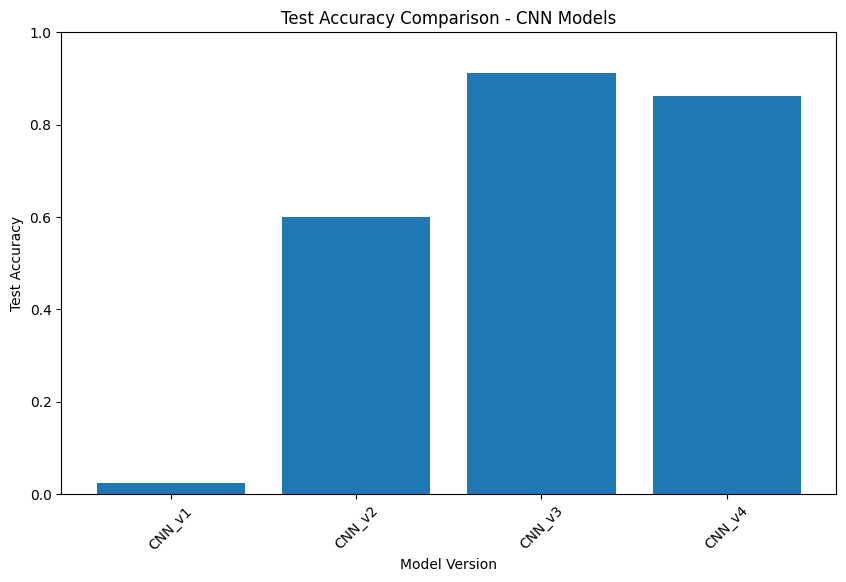

In [43]:
# Plot the test accuracy for each CNN model version
plt.figure(figsize=(10, 6))
plt.bar(results["Model_Version"], results["Test_Accuracy"])
plt.xlabel("Model Version")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison - CNN Models")
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()

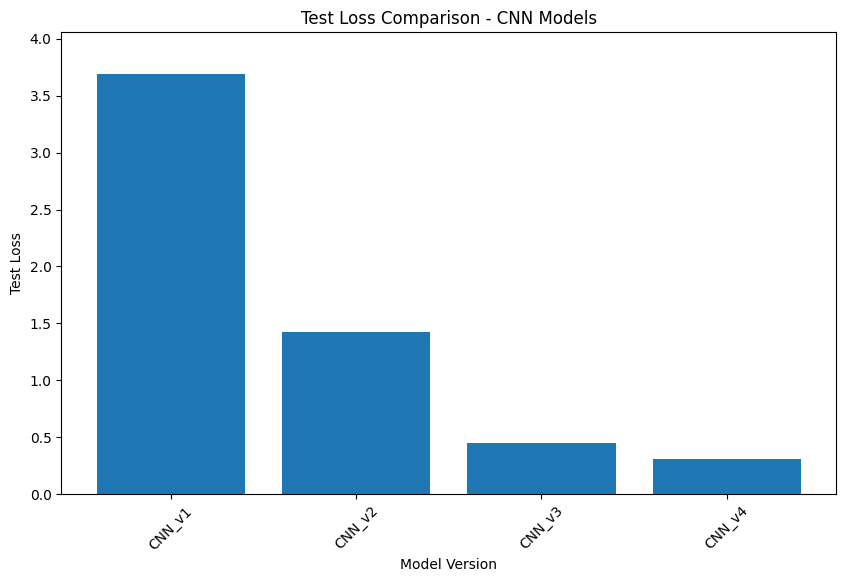

In [44]:
# Plot the test loss for each CNN model version
plt.figure(figsize=(10, 6))
plt.bar(results["Model_Version"], results["Test_Loss"])
plt.xlabel("Model Version")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison - CNN Models")
plt.ylim([0, max(results["Test_Loss"]) * 1.1])
plt.xticks(rotation=45)
plt.show()

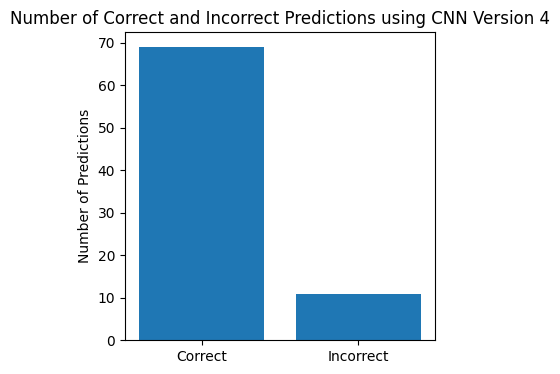

In [45]:
# Calculate number of correct and incorrect predictions for CNN Version 4
correct_predictions_cnn_v4 = np.sum(np.argmax(y_test_encoded, axis=1) == np.argmax(y_pred_v4, axis=1))
incorrect_predictions_cnn_v4 = np.sum(np.argmax(y_test_encoded, axis=1) != np.argmax(y_pred_v4, axis=1))

# Create a bar plot for CNN Version 4
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions_cnn_v4, incorrect_predictions_cnn_v4])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using CNN Version 4")
plt.show()

In [46]:
# Create a DataFrame for CNN Version 4 results
cnn_v4_results = pd.DataFrame({
    "Model_Version": ["CNN_v4"],
    "Correct": [correct_predictions_cnn_v4],
    "Incorrect": [incorrect_predictions_cnn_v4]
})
print(cnn_v4_results)

  Model_Version  Correct  Incorrect
0        CNN_v4       69         11


# Comparative Visualizations

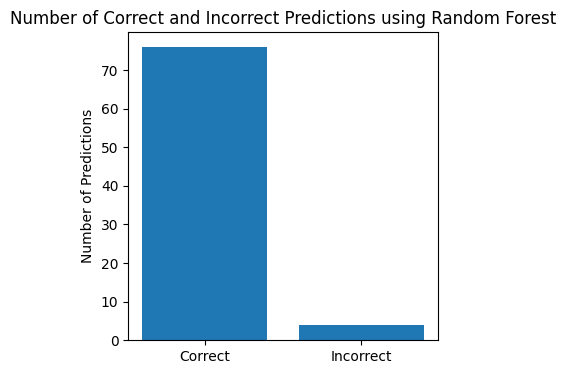

In [47]:
# Calculate number of correct and incorrect predictions using Random Forest
correct_predictions = sum(y_test_array == RF_y_pred_array)
incorrect_predictions = sum(y_test_array != RF_y_pred_array)

# Create bar plot
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Random Forest")
plt.show()

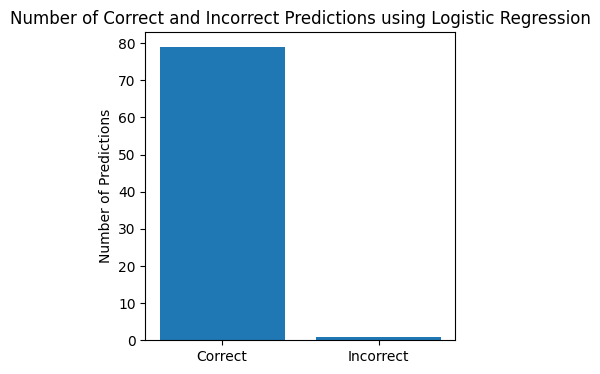

In [48]:
# Calculate number of correct and incorrect predictions using Logistic Regression
correct_predictions = sum(y_test_array == LR_y_pred_array)
incorrect_predictions = sum(y_test_array != LR_y_pred_array)

# Create bar plot
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Logistic Regression")
plt.show()

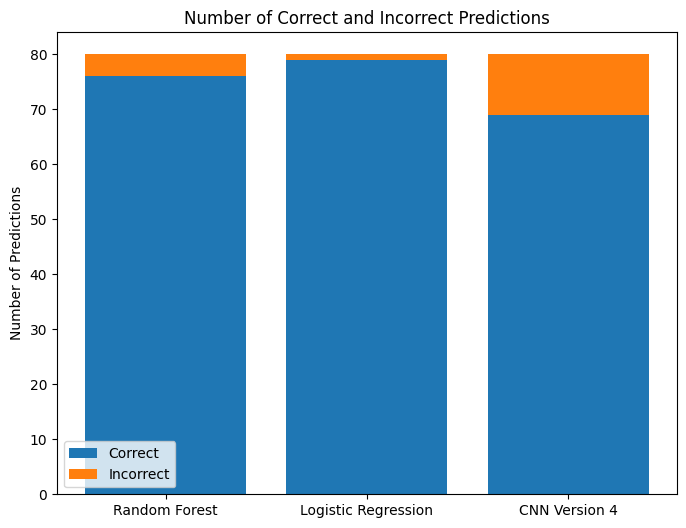

In [75]:
# Calculate number of correct and incorrect predictions for Random Forest
correct_predictions_rf = sum(y_test_array == RF_y_pred_array)
incorrect_predictions_rf = sum(y_test_array != RF_y_pred_array)

# Calculate number of correct and incorrect predictions for Logistic Regression
correct_predictions_lr = sum(y_test_array == LR_y_pred_array)
incorrect_predictions_lr = sum(y_test_array != LR_y_pred_array)

# Calculate number of correct and incorrect predictions for CNN Version 4
correct_predictions_cnn_v4 = np.sum(np.argmax(y_test_encoded, axis=1) == np.argmax(y_pred_v4, axis=1))
incorrect_predictions_cnn_v4 = np.sum(np.argmax(y_test_encoded, axis=1) != np.argmax(y_pred_v4, axis=1))

# Create stacked bar chart
labels = ["Random Forest", "Logistic Regression", "CNN Version 4"]
correct_predictions = [correct_predictions_rf, correct_predictions_lr, correct_predictions_cnn_v4]
incorrect_predictions = [incorrect_predictions_rf, incorrect_predictions_lr, incorrect_predictions_cnn_v4]

plt.figure(figsize=(8, 6))
plt.bar(labels, correct_predictions, label="Correct")
plt.bar(labels, incorrect_predictions, bottom=correct_predictions, label="Incorrect")
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions")
plt.legend(loc='lower left')
plt.show()

In [50]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 95.00%


In [72]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 98.75%


In [74]:
# Calculate the balanced accuracy score for CNN Version 4
balanced_acc_cnn_v4 = balanced_accuracy_score(np.argmax(y_test_encoded, axis=1), y_pred_cnn_v4)

# Print the balanced accuracy score for CNN Version 4
print(f"CNN Version 4 Balanced Accuracy: {balanced_acc_cnn_v4 * 100:.2f}%")

CNN Version 4 Balanced Accuracy: 86.25%


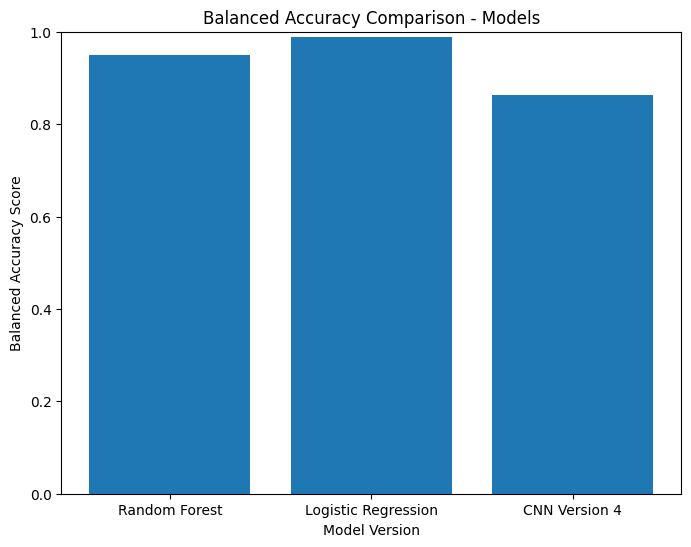

In [53]:
# Define the model versions and their corresponding balanced accuracy scores
model_versions = ['Random Forest', 'Logistic Regression', 'CNN Version 4']
balanced_accuracy_scores = [RF_balanced_accuracy_score, LR_balanced_accuracy_score, balanced_acc_cnn_v4]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(model_versions, balanced_accuracy_scores)
plt.ylim([0, 1])  # Set the y-axis limits to [0, 1]
plt.xlabel('Model Version')
plt.ylabel('Balanced Accuracy Score')
plt.title('Balanced Accuracy Comparison - Models')
plt.show()

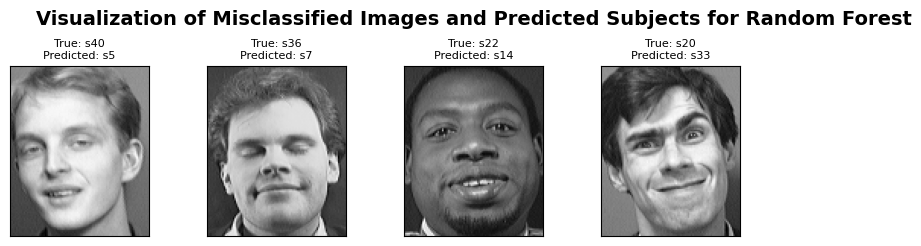

In [54]:
# Display misclassified images along with text indicating True and Predicted subjects for Random Forest

# Iterate through misclassified images and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(RFmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = RF_y_pred_array[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)
    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Random Forest", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

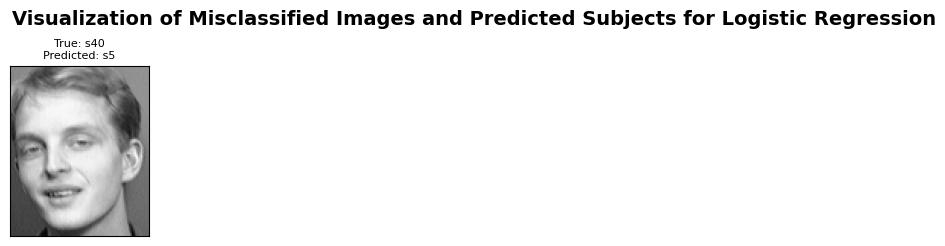

In [55]:
# Display misclassified images along with text indicating True and Predicted subjects for Logistic Regression

# Iterate through misclassified indices and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(LRmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = LR_y_pred[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)
    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Logistic Regression", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


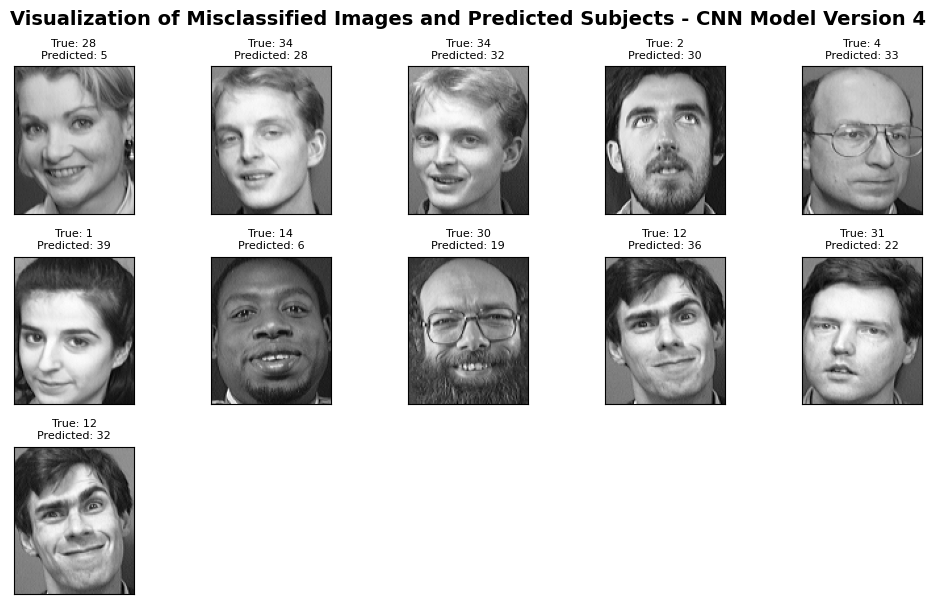

In [56]:
# Calculate misclassified indices for CNN Model Version 4
misclassified_cnn_v4 = np.where(np.argmax(y_pred_v4, axis=1) != np.argmax(y_test_encoded, axis=1))[0]

# Display misclassified images along with text indicating True and Predicted subjects for CNN Model Version 4
plt.figure(figsize=(10, 10))
for i, index in enumerate(misclassified_cnn_v4):
    img = X_test_original[index]
    true_label = np.argmax(y_test_encoded[index])
    pred_label = np.argmax(y_pred_v4[index])
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)
    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects - CNN Model Version 4", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

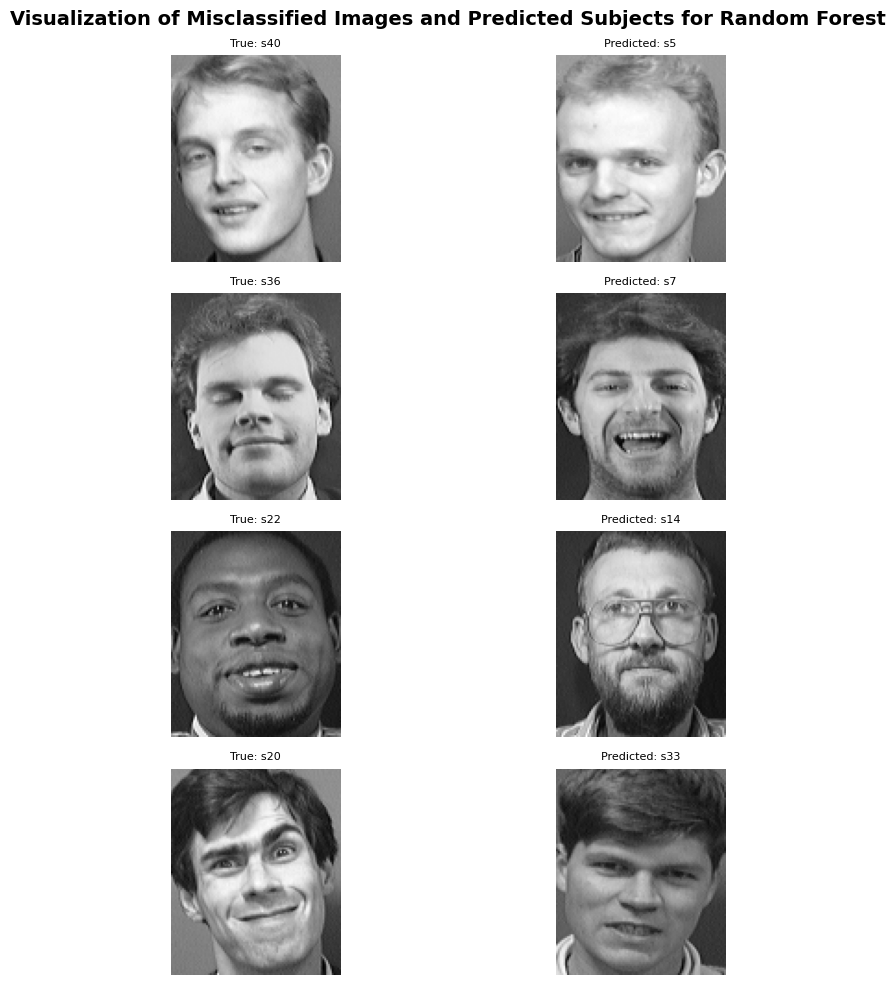

In [57]:
# Set the number of rows and columns for the subplots
rows = len(RFmisclassified)
cols = 2

# Create the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Iterate through misclassified images and display the corresponding images
for i, index in enumerate(RFmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = RF_y_pred_array[index]

    # Find the index of the first image for the predicted subject
    predicted_subject_index = np.where(y_test_array == pred_label)[0][0]
    predicted_subject_image = X_test[predicted_subject_index]

    # Plot the true subject image
    axes[i, 0].imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    axes[i, 0].set_title(f"True: {true_label}", fontsize=8)
    axes[i, 0].axis('off')

    # Plot the predicted subject image
    axes[i, 1].imshow(predicted_subject_image.reshape((112, 92)), cmap=plt.cm.gray)
    axes[i, 1].set_title(f"Predicted: {pred_label}", fontsize=8)
    axes[i, 1].axis('off')

plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Random Forest", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

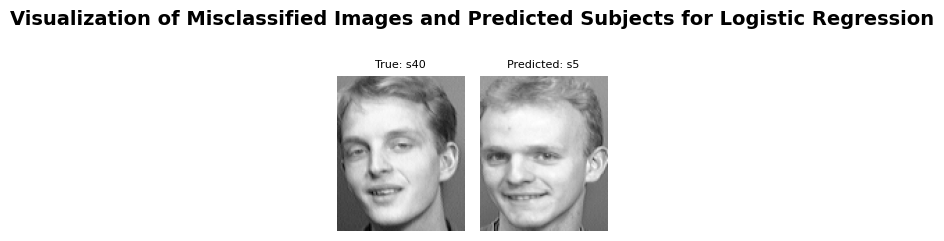

In [58]:
# Set the number of columns for the subplots
cols = 2

# Calculate the number of rows required based on the number of misclassified images
rows = (len(LRmisclassified) + 1) // cols

# Create the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(3, 3))

# Reshape axes to a 2-dimensional array if there is only one row
if rows == 1:
    axes = np.array([axes])

# Iterate through misclassified indices and display the corresponding images
for i, index in enumerate(LRmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = LR_y_pred[index]

    # Find the index of the first image for the predicted subject
    predicted_subject_index = np.where(y_test_array == pred_label)[0][0]
    predicted_subject_image = X_test[predicted_subject_index]

    # Calculate the row and column index for the subplot axes
    row = i // cols
    col = i % cols

    # Plot the true subject image
    axes[row, col].imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    axes[row, col].set_title(f"True: {true_label}", fontsize=8)
    axes[row, col].axis('off')

    # Plot the predicted subject image
    axes[row, col + 1].imshow(predicted_subject_image.reshape((112, 92)), cmap=plt.cm.gray)
    axes[row, col + 1].set_title(f"Predicted: {pred_label}", fontsize=8)
    axes[row, col + 1].axis('off')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Remove any empty subplots if the number of misclassified images is not a multiple of the number of columns
if len(LRmisclassified) % cols != 0:
    for i in range(len(LRmisclassified) % cols + 1, cols):
        fig.delaxes(axes[-1, i])

plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Logistic Regression", fontsize=14, fontweight='bold')
plt.show()

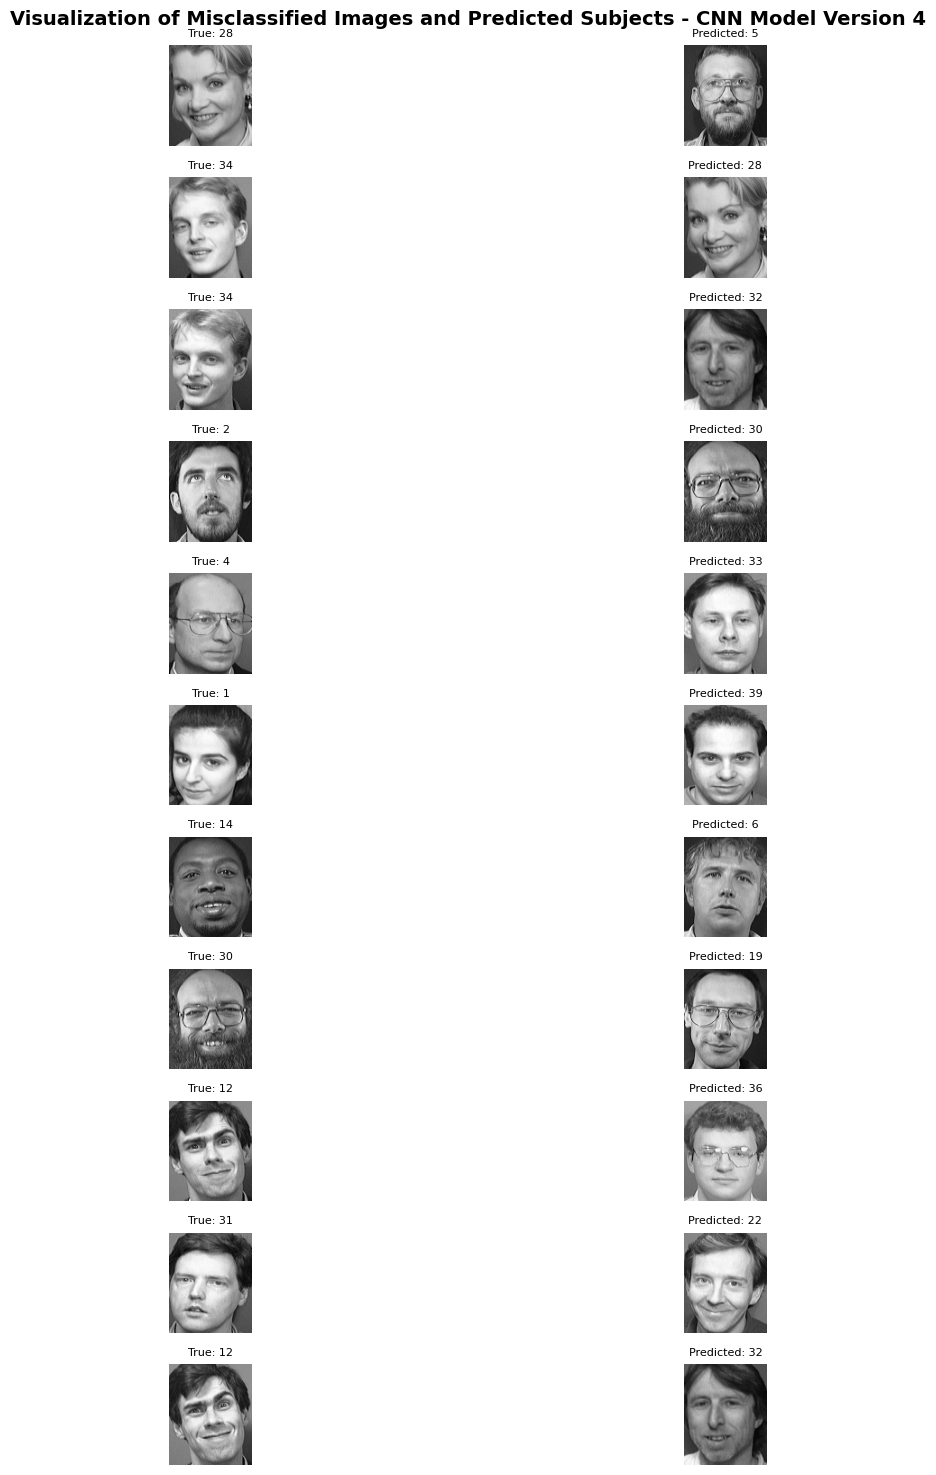

In [67]:
# Set the number of rows and columns for the subplots
rows_cnn_v4 = len(misclassified_cnn_v4)
cols = 2

# Create the subplot grid
fig, axes = plt.subplots(rows_cnn_v4, cols, figsize=(15, 15))

# Iterate through CNN Model Version 4 misclassified images and display the corresponding images
for i, index in enumerate(misclassified_cnn_v4):
    img = X_test_original[index]
    true_label = np.argmax(y_test_encoded[index])
    pred_label = np.argmax(y_pred_v4[index])

    # Find the indices of images for the predicted subject
    predicted_subject_indices = np.where(np.argmax(y_test_encoded, axis=1) == pred_label)[0]

    # Check if there are any images available for the predicted subject
    if len(predicted_subject_indices) > 0:
        # Retrieve the first image of the predicted subject
        predicted_subject_index = predicted_subject_indices[0]
        predicted_subject_image = X_test_original[predicted_subject_index]

        # Plot the true subject image
        axes[i, 0].imshow(img, cmap=plt.cm.gray)
        axes[i, 0].set_title(f"True: {true_label}", fontsize=8)
        axes[i, 0].axis('off')

        # Plot the predicted subject image
        axes[i, 1].imshow(predicted_subject_image, cmap=plt.cm.gray)
        axes[i, 1].set_title(f"Predicted: {pred_label}", fontsize=8)
        axes[i, 1].axis('off')

# Remove any empty subplots if the number of misclassified images is not a multiple of the number of columns
if rows_cnn_v4 % cols != 0:
    for i in range(rows_cnn_v4 % cols + 1, cols):
        fig.delaxes(axes[-1, i])

plt.suptitle("Visualization of Misclassified Images and Predicted Subjects - CNN Model Version 4", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()